In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import copy

In [2]:
img1 = cv.imread(r"panaroma_generation\1.jpg")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
gray1 = cv.cvtColor(img1,cv.COLOR_BGR2GRAY)

img2 = cv.imread(r"panaroma_generation\2.jpg")
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
gray2 = cv.cvtColor(img2,cv.COLOR_BGR2GRAY)

sift = cv.SIFT_create()

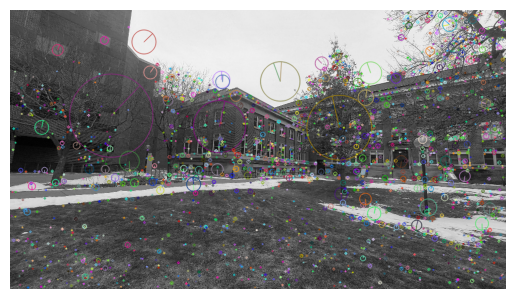

In [3]:
kp1, des1 = sift.detectAndCompute(gray1,None)
key_img1 = copy.deepcopy(img1)
key_img1 = cv.drawKeypoints(gray1,kp1,key_img1,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(key_img1)
plt.axis('off')
plt.show()  

In [4]:
print(len(kp1))
print(des1.shape)

2514
(2514, 128)


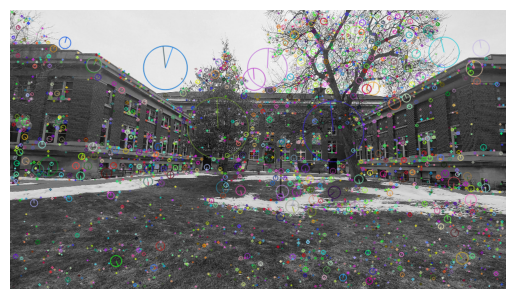

In [5]:
kp2, des2 = sift.detectAndCompute(gray2,None)
key_img2 = copy.deepcopy(img2)
key_img2 = cv.drawKeypoints(gray2,kp2,key_img2,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(key_img2)
plt.axis('off')
plt.show()

In [6]:
print(len(kp2))
print(des2.shape)

3170
(3170, 128)


The keypoints are located arounf distinctive features such as corners and edges. Also comapring the two images we can see the same points being depicted irrespective the different orientation and scale of the images. Second being more far away and with other another angle.

257


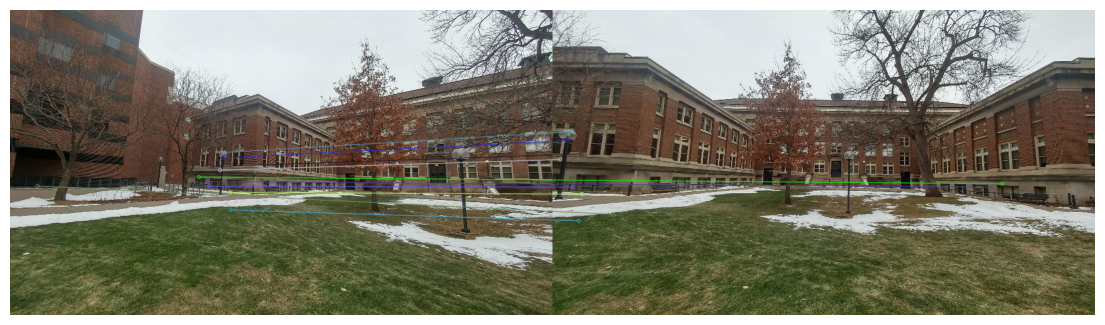

In [7]:
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

good_matches = []
for m,n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(len(good_matches))
matched_image = cv.drawMatches(img1, kp1, img2, kp2, good_matches[:10], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(14, 6))
plt.imshow(matched_image)
plt.axis('off')
plt.show()

They are total 243 good matches found by brute force algorithm. I have depicted 50 of them in the above image.

268


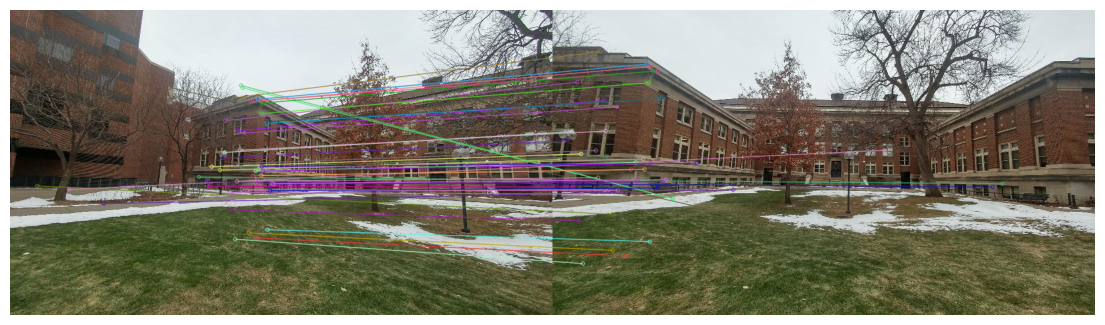

In [8]:
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(len(good_matches))
matched_image = cv.drawMatches(img1, kp1, img2, kp2, good_matches[:50], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(14, 6))
plt.imshow(matched_image)
plt.axis('off')
plt.show()

In [9]:
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

homography_matrix, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
print(homography_matrix)

[[-5.69835075e+01  1.94129927e+00  2.05140405e+04]
 [-1.72862393e+01 -3.45440911e+01  1.06604643e+04]
 [-5.94242816e-02  2.39456480e-04  1.00000000e+00]]


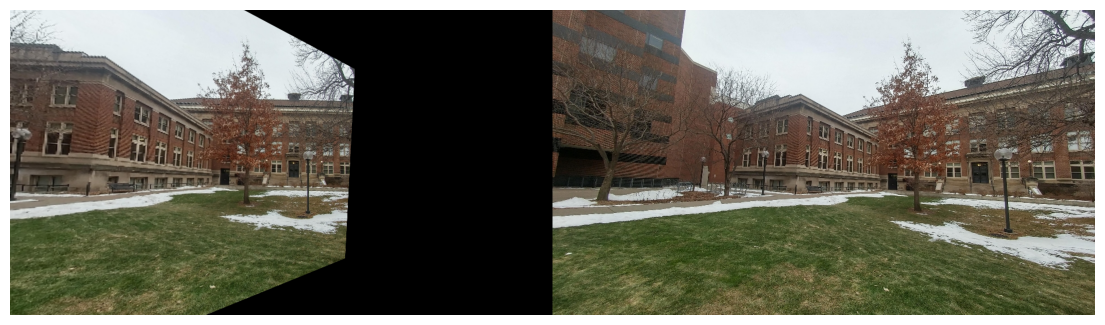

In [10]:
height, width, _ = img2.shape
transformed_img1 = cv.warpPerspective(img1, homography_matrix, (width, height))
result = np.concatenate((transformed_img1, img1), axis=1)

plt.figure(figsize=(14, 6))
plt.imshow(result)
plt.axis('off')
plt.show()

The image1 perspective changed to the form of image2. Look how it looks identical.

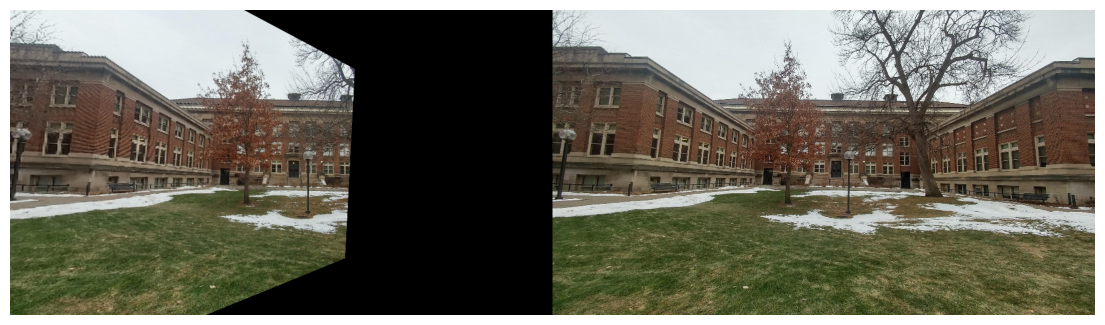

In [11]:
result = np.concatenate((transformed_img1, img2), axis=1)
plt.figure(figsize=(14, 6))
plt.imshow(result)
plt.axis('off')
plt.show()

The image on the left is transformed image 1 and on the right is image2. Look how is the perspective of both the image the same.

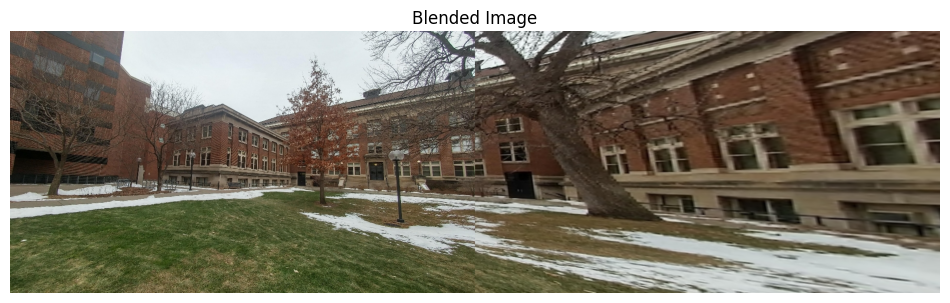

In [12]:
image1 = cv.imread('panaroma_generation/2.jpg')
image2 = cv.imread('panaroma_generation/1.jpg')

descriptor = cv.SIFT_create()
(kps1, features1) = descriptor.detectAndCompute(image1, None)
(kps2, features2) = descriptor.detectAndCompute(image2, None)
kps1 = np.float32([kp.pt for kp in kps1])
kps2 = np.float32([kp.pt for kp in kps2])
matcher = cv.DescriptorMatcher_create("FlannBased")
rawMatches = matcher.knnMatch(features1, features2, 2)

matches = []
for m in rawMatches:
    if len(m) == 2 and m[0].distance < m[1].distance * 0.75:
        matches.append((m[0].trainIdx, m[0].queryIdx))

ptsA = np.float32([kps1[i] for (_, i) in matches])
ptsB = np.float32([kps2[i] for (i, _) in matches])
(H, status) = cv.findHomography(ptsA, ptsB, cv.RANSAC, 0.2)

result = cv.warpPerspective( image1, H, (image2.shape[1] + image2.shape[1], image1.shape[0]))
result[0 : image2.shape[0], 0 : image2.shape[1]] = image2

plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.title('Blended Image')
plt.axis('off')
plt.show()

In [13]:
stitcher = cv.Stitcher.create(cv.Stitcher_PANORAMA)
img_list = []
for i in range(1,9):
    temp = cv.imread(f"panaroma_generation\{i}.jpg")
    temp = cv.cvtColor(temp, cv.COLOR_BGR2RGB)
    img_list.append(temp)
status, panorama = stitcher.stitch(img_list)

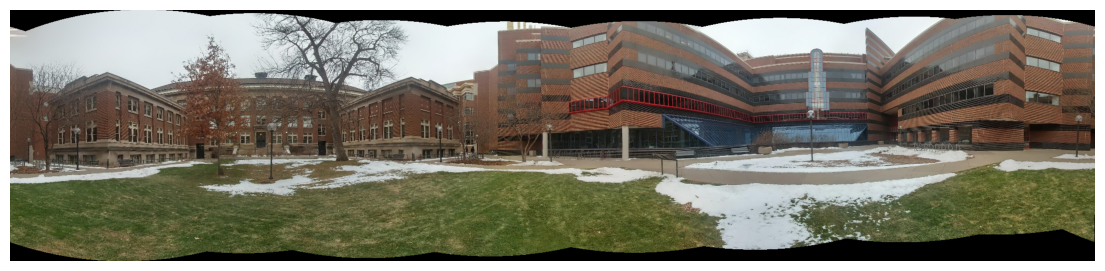

In [14]:
if status == cv.Stitcher_OK:
    plt.figure(figsize=(14, 6))
    plt.imshow(panorama)
    plt.axis('off')
    plt.show()
else:
    print("Error during stitching:", status)